In [17]:
#!/usr/bin/python
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from weakref import ref
from scipy.integrate import odeint, solve_ivp

class AllenCahn:
    """
    An implementation of the Allen-Cahn equation in two dimensions, using the method
    of lines and explicit finite differences
    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        kappa (float): reaction rate
        d (float): diffusion coefficient
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
    """

    def __init__(self, nx, ny, kappa=1.0, d=1.0, Lx=1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.d = d
        self.kappa = kappa
       
    def _laplace(self, grid):
        """
        Apply the two-dimensional Laplace operator to a square array
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE
        #  My 10 line solution is vectorized in numpy, and so it avoids using a for loop 
        #  There are several valid ways to implement the boundary conditions
        #
        ################################################################################
        
        # lap = np.zeros((self.ny, self.nx))

        # enforce reflection boundary conditions by padding rows and columns
        lap = np.zeros((self.nx, self.ny))
        
        for i in range(self.nx):
            for j in range(self.ny):
                if not(i == 0 or j == 0 or i == self.nx - 1 or j == self.ny - 1):
                    lap[i, j] = grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                    
                lap[i, j] = lap[i, j] - grid[i, j] * 4
            
        return lap / (self.dx * self.dy)

    def _reaction(self, y):
        """
        Bistable reaction term
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE.
        #
        #
        ################################################################################
        return y * (1 - y**2)

    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE
        #  My solution primariy calls private methods
        #
        #
        ################################################################################
        y = y.reshape((self.ny, self.nx))
        out = self.kappa * self._reaction(y) + self.d * self._laplace(y)
        return out.flatten()


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the odeint solver
        **kwargs are passed to scipy.integrate.solve_ivp
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE
        #  My solution is five lines, and it mainly involves setting things up to be
        #  passed to scipy.integrate.solve_ivp, and then returning the results
        #
        #
        ################################################################################
        tpts = np.linspace(t_min, t_max, nt)
        out = solve_ivp(self.rhs, (t_min, t_max), y0.flatten(), t_eval=tpts, **kwargs)
        sol = out.y.T
        tpts =  out.t
        return tpts, sol.reshape((len(tpts), self.ny, self.nx))

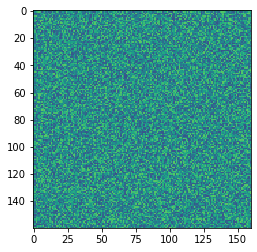

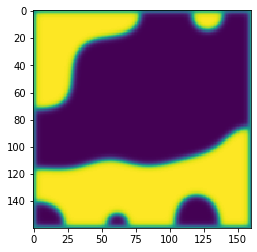

In [18]:
## Run an example simulation and plot the before and after
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5
model = AllenCahn(*ic.shape, kappa=1e1, d=1e-3)
tpts, sol = model.solve(ic, 0, 8, 400, method="DOP853")


plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)

In [19]:
#!/usr/bin/python
import numpy as np
from scipy.integrate import solve_ivp


def make_initial_conditions(n):
    """
    Make a bump-shaped initial conditions array
    """
    xx, yy = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
    rr =  (xx**2 + yy**2)**0.5
    u_ic = 1 - 0.5 * np.copy(np.exp(-rr**2 - xx**2))
    v_ic = 0.25 * np.copy(np.exp(-rr**2))
    return u_ic, v_ic

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        uv2 = u * (v**2)
        rxn_u = -uv2 + self.b * (1 - u)
        rxn_v = uv2 - self.kappa * v
        y_out = np.hstack([rxn_u, rxn_v])
        return y_out



    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
         
        y = np.reshape(y, (self.nx, self.ny))
        yk = np.fft.fft2(y)
        lap = -self.ksq * yk
        lap = np.fft.ifft2(lap)
        return np.real(lap).flatten()


    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        lap_u = self._laplace(u)
        lap_v = self._laplace(v)
        u_out = self.du * lap_u
        v_out = self.dv * lap_v
        y_out = np.hstack([u_out, v_out])
        return y_out



    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        
        out = self._reaction(y) + self._diffusion(y)
        return out


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver

        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp

        """

        u0, v0 = y0
        tpts = np.linspace(t_min, t_max, nt)
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=tpts, **kwargs)
        sol = out.y.T
        
        u, v = sol[:, :self.nx * self.ny], sol[:, self.nx * self.ny:]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v, (nt, self.ny, self.nx))
        return tpts, np.stack([u, v], axis=-1)



Imaginary residual is: 0.0


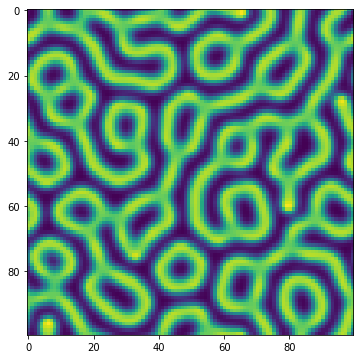

In [20]:
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((100, 100))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])